In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca

ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [32]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = {c: [v[0] / 2, v[1] / 2] for (c, v) in configs.DEFAULT_MOVEMENT_RANGES.items()}

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "log_weighted_sum_intensity", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {},  # {"fwhm": 0.02},
        }

In [9]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

    new_dir = work_dir / f"work_dir_{DEFAULT_RANDOM_SEED}"
    new_dir.mkdir(exist_ok=True)

    files = work_dir.glob("*")
    for f in files:
        if f.is_file():
            shutil.copy2(f, new_dir)
    os.chdir(new_dir)

In [10]:
def print_beam_attributes(cp, loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(
            opt_common._get_weighted_sum_intensity_from_hist(cp, hist, 2)
        ),
        "kl_divergence": lambda hist: opt_common._get_kl_divergence_with_gaussian_from_hist(cp, hist),
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [11]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange=[-detector_x / 2, detector_x / 2],
    yrange=[-detector_y / 2, detector_y / 2],
    nbins_h=1024,
    nbins_v=1024,
    use_denoised=False,
    random_seed=111,
    add_noise=True,
    calculate_over_noise=False,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
)

xrange_plot = [x / 5 for x in cp.xrange]
yrange_plot = [y / 5 for y in cp.yrange]

ppm = opt_common.PlotParameters(
    xrange=xrange_plot, yrange=yrange_plot, nbins_h=cp.nbins_h // 5, nbins_v=cp.nbins_v // 5
)  # xrange=xrange_plot, yrange=yrange_plot)#, )

In [12]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [13]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-12.5, 12.5], 'hb_2': [-12.5, 12.5], 'hb_pitch': [-0.001, 0.001], 'hb_trans': [-0.015, 0.015], 'vb_bender': [-10.0, 10.0], 'vb_pitch': [-0.001, 0.001], 'vb_trans': [-0.015, 0.015]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['fwhm', 'log_weighted_sum_intensity', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100}


In [14]:
input_beam_path = "primary_optics_system_beam.dat"
clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


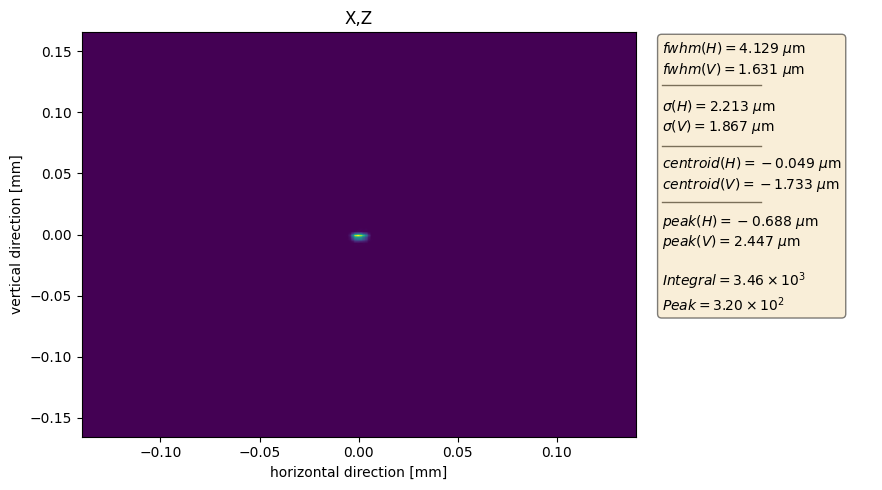

In [15]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [17]:
attribs_focus = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist, dw, "Focused beam")

Focused beam system fwhm: 8.412e-03
Focused beam system log_weighted_sum_intensity: 1.224e+01
Focused beam system peak_distance: 1.063e-03


In [18]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)

Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [19]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-172.8, -162.3, 0.17178733853924988, -0.012, 425.4, 0.17161733853924988, 0.0143]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-4.7957148075284675, -1.3283111007830026, 0.00012656254617960327, -0.006019505855221473, 6.415753086109078, -0.00027429213013284383, 0.014346332574899392]


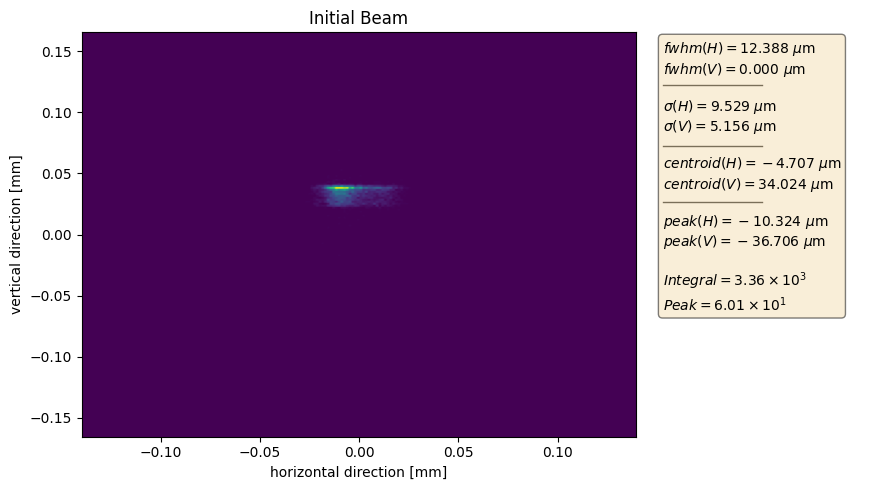

Perturbed beam system fwhm: 1.403e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01
Perturbed beam system peak_distance: 3.921e-02


In [20]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

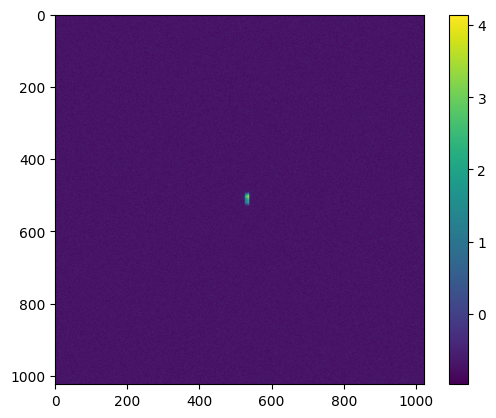

In [21]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [22]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITHOUT REMOVING NOISE

In [23]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

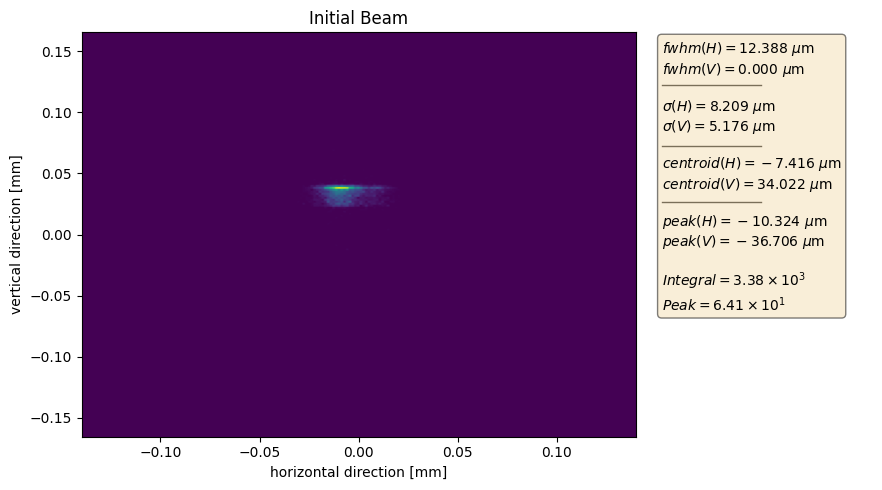

In [24]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [28]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.403e+00
Perturbed beam system log_weighted_sum_intensity: 1.224e+01
Perturbed beam system peak_distance: 3.921e-02


In [33]:
opt_params = OptimizationParameters()

In [34]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
)

In [35]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [36]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 20:25:41,249] A new study created in memory with name: no-name-198f1235-4226-4522-a9a5-f81a494fe76e


In [37]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-05-12 20:25:52,137] Trial 0 finished with values: [1.40270515051206, 12.240933662052841, 0.03921365641918598] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_tra

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:25:58,297] Trial 1 finished with values: [1.4026439671734452, 12.240735264333345, 0.03204881288945489] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008, 'vb_bender': -4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0144}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:06,924] Trial 2 finished with values: [1.4026373780393353, 12.241067170370753, 0.02263763252105771] and parameters: {'hb_1': -2.5, 'hb_2': -6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.014700000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.00084, 'vb_trans': 0.005000000000000001}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:11,405] Trial 3 finished with values: [1.4026373780393353, 12.241048222173028, 0.033577208011650796] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0115, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.008800000000000002}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:19,076] Trial 4 finished with values: [2.175053675032646, 12.241235070735277, 0.11717188035553171] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0023, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.014199999999999999}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:26,514] Trial 5 finished with values: [1.4027644487397237, 12.24089065724323, 0.11889024255304767] and parameters: {'hb_1': -1.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 1.0, 'vb_pitch': -0.00046, 'vb_trans': 0.0149}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:31,020] Trial 6 finished with values: [2.175053675032646, 12.24123450470403, 0.07069082423319044] and parameters: {'hb_1': -9.5, 'hb_2': 3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.002899999999999998, 'vb_bender': 5.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.002999999999999999}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:38,403] Trial 7 finished with values: [1.4026373780393353, 12.241458195086711, 0.1407076895694091] and parameters: {'hb_1': -4.5, 'hb_2': 11.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.009400000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.013500000000000002}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:46,062] Trial 8 finished with values: [1.4026439671734452, 12.241089353998403, 0.10287098437568347] and parameters: {'hb_1': 7.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0024999999999999988, 'vb_bender': -4.0, 'vb_pitch': -0.00098, 'vb_trans': -0.0139}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:26:53,938] Trial 9 finished with values: [1.4027879790877382, 12.241602948727731, 0.08717687234402134] and parameters: {'hb_1': -11.5, 'hb_2': -9.5, 'hb_pitch': -0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': 1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0097}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:02,547] Trial 10 finished with values: [2.175053675032646, 12.241001791186173, 0.03499798104048857] and parameters: {'hb_1': 1.5, 'hb_2': -1.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.009000000000000001, 'vb_bender': -7.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.0009999999999999992}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:13,574] Trial 11 finished with values: [1.4026373780393353, 12.241105771578605, 0.04012060223303311] and parameters: {'hb_1': -0.5, 'hb_2': -9.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.009000000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.0008, 'vb_trans': -0.0107}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:21,808] Trial 12 finished with values: [1.4026373780393353, 12.241040053224035, 0.03763299217125795] and parameters: {'hb_1': 4.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0016999999999999984, 'vb_bender': -3.0, 'vb_pitch': -7.999999999999999e-05, 'vb_trans': -0.005099999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:31,831] Trial 13 finished with values: [1.4026373780393353, 12.240947290284547, 0.03974690479247757] and parameters: {'hb_1': 2.5, 'hb_2': -11.5, 'hb_pitch': 0.0, 'hb_trans': 0.0108, 'vb_bender': -4.0, 'vb_pitch': -0.00068, 'vb_trans': -0.011699999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:43,340] Trial 14 finished with values: [1.4026439671734452, 12.241201879210132, 0.061033786640883166] and parameters: {'hb_1': 2.5, 'hb_2': -5.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.005999999999999998, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.010900000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:52,558] Trial 15 finished with values: [1.4026298475624497, 12.241281927303584, 0.030873089379873663] and parameters: {'hb_1': 0.5, 'hb_2': -11.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.006200000000000001, 'vb_bender': -8.0, 'vb_pitch': -0.00056, 'vb_trans': 0.0102}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:27:58,910] Trial 16 finished with values: [1.4026373780393353, 12.240881303003201, 0.046317573670992526] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.0022000000000000006, 'vb_bender': -7.0, 'vb_pitch': -0.00052, 'vb_trans': -0.013099999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:28:11,596] Trial 17 finished with values: [1.402742800470942, 12.240902043218089, 0.033202793254316944] and parameters: {'hb_1': -1.5, 'hb_2': -4.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.0023, 'vb_bender': 0.0, 'vb_pitch': -0.00068, 'vb_trans': -0.0101}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:28:21,672] Trial 18 finished with values: [1.4026373780393353, 12.240887677761451, 0.028254837634677062] and parameters: {'hb_1': 6.5, 'hb_2': -5.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.014500000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.0007, 'vb_trans': -0.0093}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:28:32,388] Trial 19 finished with values: [1.4026439671734452, 12.241064963354406, 0.03808899271599847] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': 0.0, 'hb_trans': 0.013400000000000002, 'vb_bender': -2.0, 'vb_pitch': -0.0007, 'vb_trans': -0.003899999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:28:43,841] Trial 20 finished with values: [2.175053675032646, 12.241050580697244, 0.07966952235265777] and parameters: {'hb_1': 0.5, 'hb_2': -8.5, 'hb_pitch': 0.0, 'hb_trans': 0.001800000000000003, 'vb_bender': 3.0, 'vb_pitch': -0.00043999999999999996, 'vb_trans': -0.010199999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:28:52,771] Trial 21 finished with values: [1.4026326714960196, 12.24113048231103, 0.02277901352525688] and parameters: {'hb_1': 7.5, 'hb_2': -3.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0040999999999999995, 'vb_bender': -8.0, 'vb_pitch': 0.00076, 'vb_trans': 0.0074}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:03,615] Trial 22 finished with values: [1.4026373780393353, 12.241030887897583, 0.02015166427138197] and parameters: {'hb_1': 2.5, 'hb_2': -7.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0103, 'vb_bender': -4.0, 'vb_pitch': -0.00086, 'vb_trans': -0.013}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:14,007] Trial 23 finished with values: [1.4026326714960196, 12.240878167935195, 0.038193653016801436] and parameters: {'hb_1': -6.5, 'hb_2': -0.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.006100000000000001, 'vb_bender': -3.0, 'vb_pitch': -7.999999999999999e-05, 'vb_trans': -0.004599999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:21,757] Trial 24 finished with values: [1.4026373780393353, 12.240738280695552, 0.024046208799378185] and parameters: {'hb_1': 11.5, 'hb_2': -4.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.0131, 'vb_bender': -7.0, 'vb_pitch': -0.0008, 'vb_trans': -0.0116}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:33,447] Trial 25 finished with values: [1.4026326714960196, 12.241192320501195, 0.034804545947470955] and parameters: {'hb_1': 11.5, 'hb_2': -2.5, 'hb_pitch': 0.0, 'hb_trans': 0.012100000000000003, 'vb_bender': -9.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': -0.0136}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:45,805] Trial 26 finished with values: [1.4026373780393353, 12.241295101150582, 0.046317573670992526] and parameters: {'hb_1': 8.5, 'hb_2': -11.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.011700000000000002, 'vb_bender': -4.0, 'vb_pitch': -0.0005, 'vb_trans': -0.011899999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:29:58,424] Trial 27 finished with values: [1.4026373780393353, 12.241232479136682, 0.05091428131576282] and parameters: {'hb_1': -1.5, 'hb_2': -3.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.007300000000000001, 'vb_bender': -4.0, 'vb_pitch': -0.0005, 'vb_trans': -0.013699999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:09,394] Trial 28 finished with values: [1.4026439671734452, 12.241135148519936, 0.013050707152634948] and parameters: {'hb_1': 0.5, 'hb_2': -3.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.0020999999999999994, 'vb_bender': -3.0, 'vb_pitch': -0.0009, 'vb_trans': 0.001400000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:22,648] Trial 29 finished with values: [1.4026750298173347, 12.241136928526759, 0.050367071204556364] and parameters: {'hb_1': 11.5, 'hb_2': -6.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0002999999999999982, 'vb_bender': -2.0, 'vb_pitch': -0.001, 'vb_trans': -0.0124}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:35,893] Trial 30 finished with values: [1.4026439671734452, 12.240812872999342, 0.03362900817125417] and parameters: {'hb_1': 10.5, 'hb_2': -2.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0086, 'vb_bender': -3.0, 'vb_pitch': -0.00078, 'vb_trans': -0.0133}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:30:48,620] Trial 31 finished with values: [1.4026524388718187, 12.240922700025607, 0.028445762088012732] and parameters: {'hb_1': 5.5, 'hb_2': -3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.002700000000000001, 'vb_bender': -2.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.007099999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:04,776] Trial 32 finished with values: [1.402662793100345, 12.241194459315127, 0.018072293487563614] and parameters: {'hb_1': 0.5, 'hb_2': 1.5, 'hb_pitch': 0.0, 'hb_trans': 0.011000000000000003, 'vb_bender': -2.0, 'vb_pitch': -0.00076, 'vb_trans': -0.002599999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:19,503] Trial 33 finished with values: [1.4026524388718187, 12.24114876630287, 0.05221019462480498] and parameters: {'hb_1': -8.5, 'hb_2': 1.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.004700000000000003, 'vb_bender': -2.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': 0.007500000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:34,966] Trial 34 finished with values: [1.4026524388718187, 12.240674330766495, 0.021948209056044235] and parameters: {'hb_1': 11.5, 'hb_2': 0.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.000899999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00078, 'vb_trans': -0.0116}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:31:48,237] Trial 35 finished with values: [1.4026524388718187, 12.240953523226196, 0.011056589562790552] and parameters: {'hb_1': 11.5, 'hb_2': -1.5, 'hb_pitch': 0.0, 'hb_trans': -0.003899999999999999, 'vb_bender': -4.0, 'vb_pitch': -0.001, 'vb_trans': -0.0081}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:04,272] Trial 36 finished with values: [1.4026373780393353, 12.24108625398416, 0.0253462160465265] and parameters: {'hb_1': 8.5, 'hb_2': 0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.0059000000000000025, 'vb_bender': -6.0, 'vb_pitch': -0.00096, 'vb_trans': -0.014499999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:22,046] Trial 37 finished with values: [1.4026373780393353, 12.240598230339584, 0.04229021066248308] and parameters: {'hb_1': 11.5, 'hb_2': -1.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.00010000000000000113, 'vb_bender': -3.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.0136}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:43,453] Trial 38 finished with values: [1.4026373780393353, 12.240937639532403, 0.028716796875000006] and parameters: {'hb_1': 6.5, 'hb_2': 0.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.0142, 'vb_bender': -7.0, 'vb_pitch': -0.00076, 'vb_trans': -0.0135}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:32:59,734] Trial 39 finished with values: [1.4026373780393353, 12.241065326853036, 0.02041635194912153] and parameters: {'hb_1': 10.5, 'hb_2': -9.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.003899999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00082, 'vb_trans': -0.010499999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:17,801] Trial 40 finished with values: [1.4026439671734452, 12.241025171875958, 0.020198445662571087] and parameters: {'hb_1': -4.5, 'hb_2': -8.5, 'hb_pitch': 0.0, 'hb_trans': 0.007700000000000002, 'vb_bender': -3.0, 'vb_pitch': -0.00096, 'vb_trans': 0.0085}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:33:35,700] Trial 41 finished with values: [1.4026373780393353, 12.24107570286469, 0.018548872546869502] and parameters: {'hb_1': 6.5, 'hb_2': 1.5, 'hb_pitch': 0.0, 'hb_trans': 0.013800000000000003, 'vb_bender': -4.0, 'vb_pitch': -0.0009, 'vb_trans': 0.013900000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:06,131] Trial 42 finished with values: [1.4026439671734452, 12.240983856194179, 0.017076266593369336] and parameters: {'hb_1': 11.5, 'hb_2': -0.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0081, 'vb_bender': -3.0, 'vb_pitch': -0.00086, 'vb_trans': -0.011099999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:23,721] Trial 43 finished with values: [1.4026891489735211, 12.241096989505914, 0.031772600975683574] and parameters: {'hb_1': 12.5, 'hb_2': 3.5, 'hb_pitch': 0.0, 'hb_trans': -0.0016999999999999984, 'vb_bender': -1.0, 'vb_pitch': -0.00068, 'vb_trans': -0.0112}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:34:42,715] Trial 44 finished with values: [1.4026891489735211, 12.240931970582224, 0.01676983026699548] and parameters: {'hb_1': 11.5, 'hb_2': -5.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.005600000000000001, 'vb_bender': -1.0, 'vb_pitch': -0.00074, 'vb_trans': 0.00020000000000000052}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:01,926] Trial 45 finished with values: [1.4026750298173347, 12.24109865293164, 0.014937652331736637] and parameters: {'hb_1': 12.5, 'hb_2': -4.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.0028000000000000004, 'vb_bender': -10.0, 'vb_pitch': -0.00082, 'vb_trans': 0.010600000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:21,570] Trial 46 finished with values: [1.4026298475624497, 12.2408535139686, 0.013964774502669225] and parameters: {'hb_1': 5.5, 'hb_2': 4.5, 'hb_pitch': 0.0, 'hb_trans': -0.003899999999999999, 'vb_bender': -3.0, 'vb_pitch': 0.00034, 'vb_trans': 0.005400000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:35:38,725] Trial 47 finished with values: [2.175053675032646, 12.241223774066775, 0.0874470855497694] and parameters: {'hb_1': 12.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.012100000000000003, 'vb_bender': -6.0, 'vb_pitch': -0.0005, 'vb_trans': 0.011600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:01,251] Trial 48 finished with values: [1.4026891489735211, 12.241109967235552, 0.021108651510923615] and parameters: {'hb_1': 11.5, 'hb_2': -7.5, 'hb_pitch': 0.0, 'hb_trans': 0.011500000000000003, 'vb_bender': -1.0, 'vb_pitch': -0.00084, 'vb_trans': -0.010199999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:36:30,593] Trial 49 finished with values: [1.4027644487397237, 12.240991665396546, 0.031730693624268586] and parameters: {'hb_1': 12.5, 'hb_2': 0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': 0.003300000000000001, 'vb_bender': 1.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.010799999999999999}. 


/tmp/ipykernel_4113294/2661359174.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

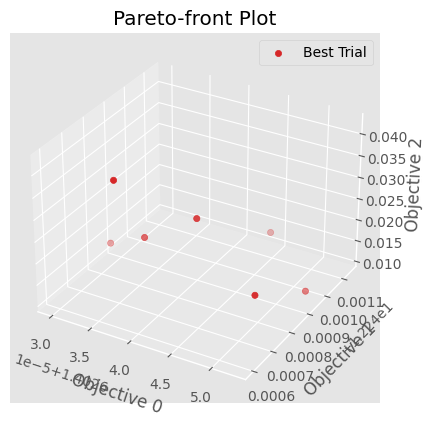

In [38]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
# plt.xscale('log')
# plt.yscale('log')
# plt.scatter(*attribs_focus.values(), color='green')

In [54]:
opt_params.params["loss_parameters"]

['fwhm', 'log_weighted_sum_intensity', 'peak_distance']

#### The FWHM (h) was consistently calculated to be too high, so the optimization did not optimize the h direction at all

/tmp/ipykernel_4113294/2536437509.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='fwhm'>

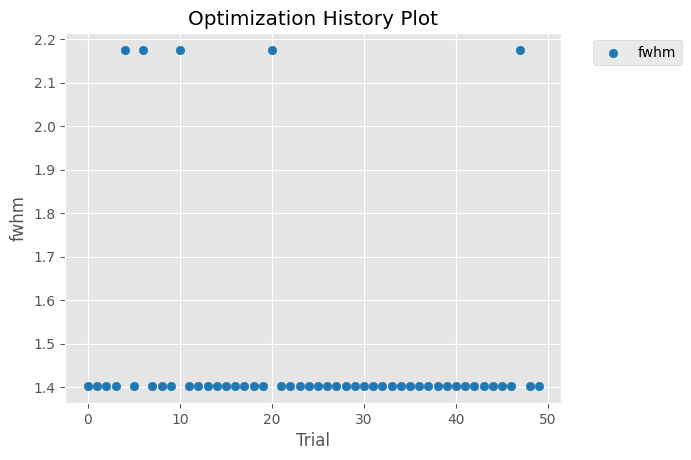

In [61]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="fwhm"
)

/tmp/ipykernel_4113294/605322601.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='lwsi'>

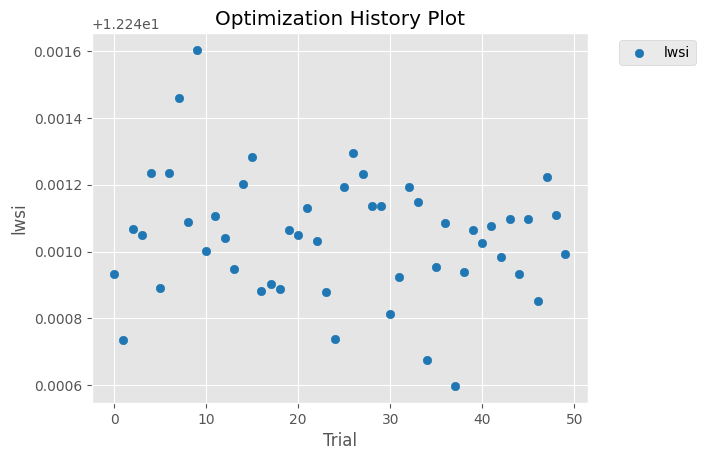

In [60]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="lwsi"
)

/tmp/ipykernel_4113294/3529082244.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study, target=lambda t: t.values[2], target_name='peak_location')


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='peak_location'>

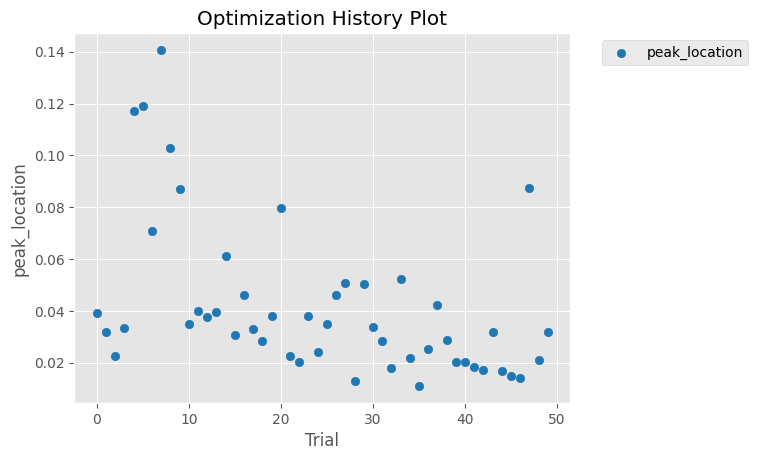

In [51]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[2], target_name="peak_location"
)

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

-0.5973667861989576 207054.0738232885
-0.8846540349466934 207054.6983743138
-1.4957519415264393 207136.88803012195
-0.9759403234939992 207041.4576644174
-1.6615764686343817 207099.27014827204
-0.3200871893404762 207025.7023206027
-1.4280892837880264 207078.5593396693


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026439671734452, 12.240735264333345, 0.03204881288945489]


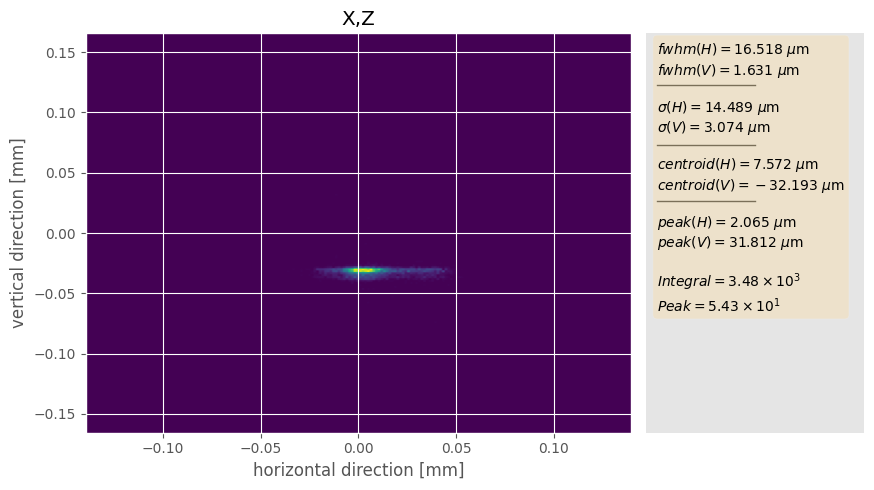

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026373780393353, 12.240738280695552, 0.024046208799378185]


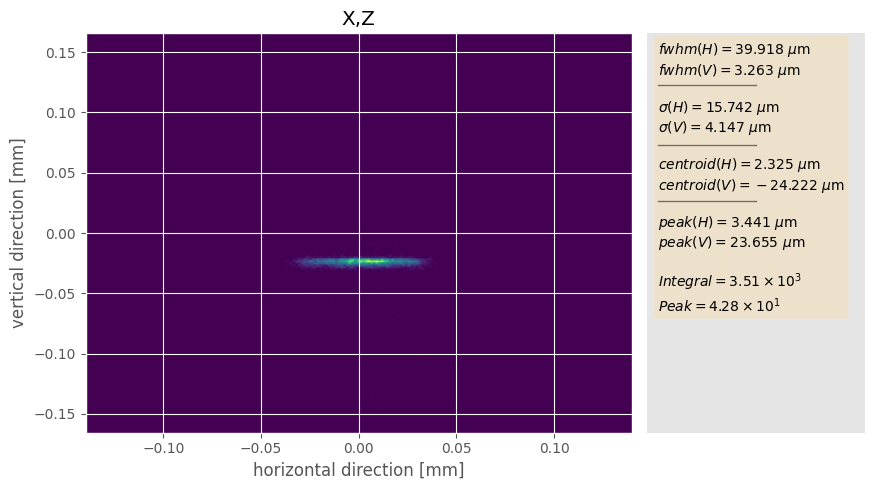

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026439671734452, 12.241135148519936, 0.013050707152634948]


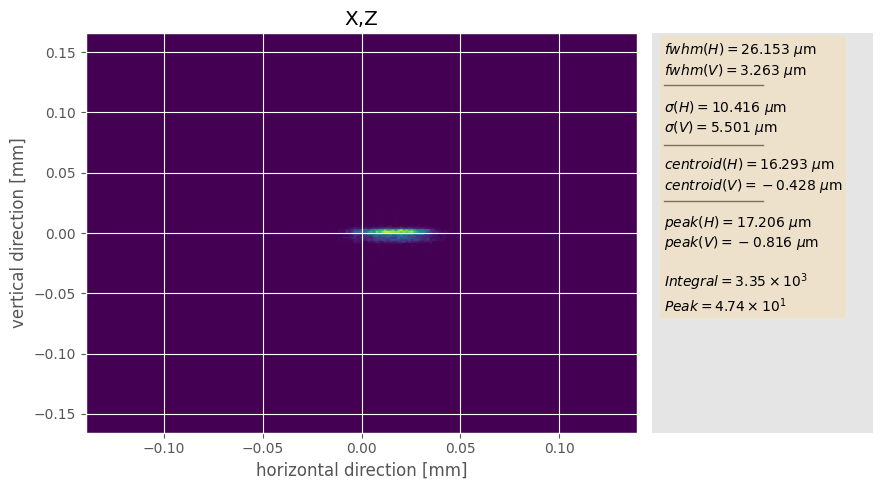

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026524388718187, 12.240674330766495, 0.021948209056044235]


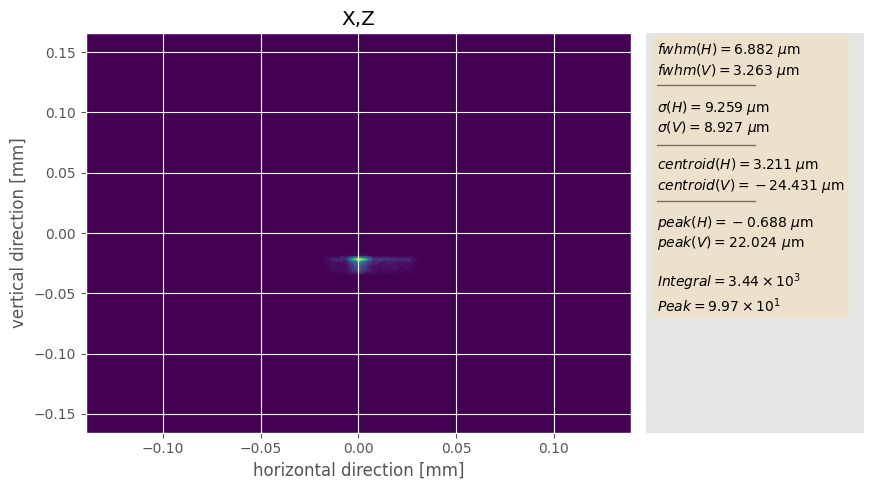

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026524388718187, 12.240953523226196, 0.011056589562790552]


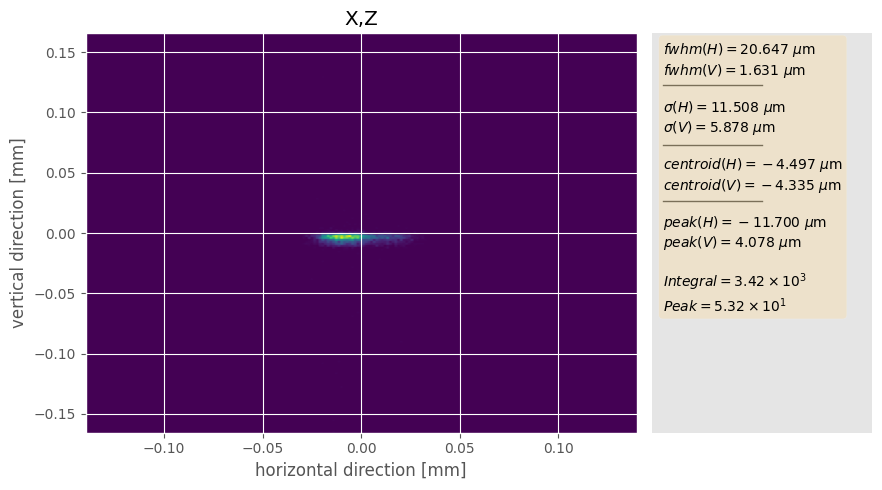

[1.4026373780393353, 12.240598230339584, 0.04229021066248308]


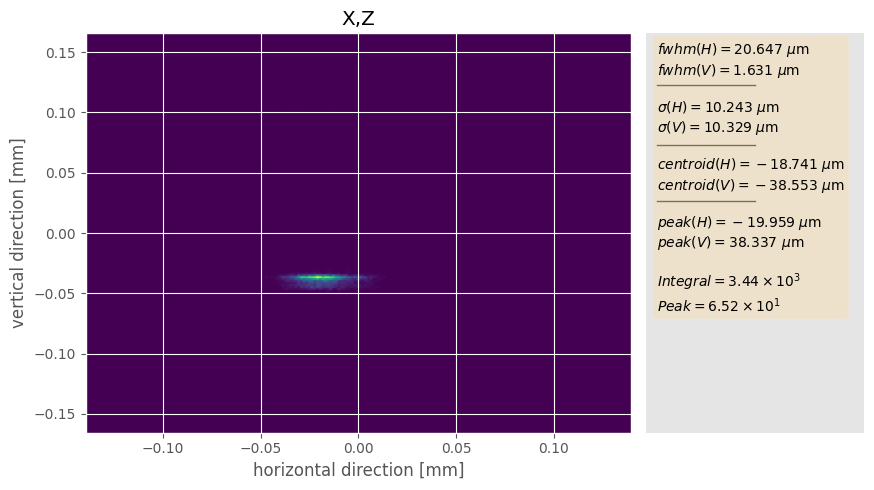

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[1.4026298475624497, 12.2408535139686, 0.013964774502669225]


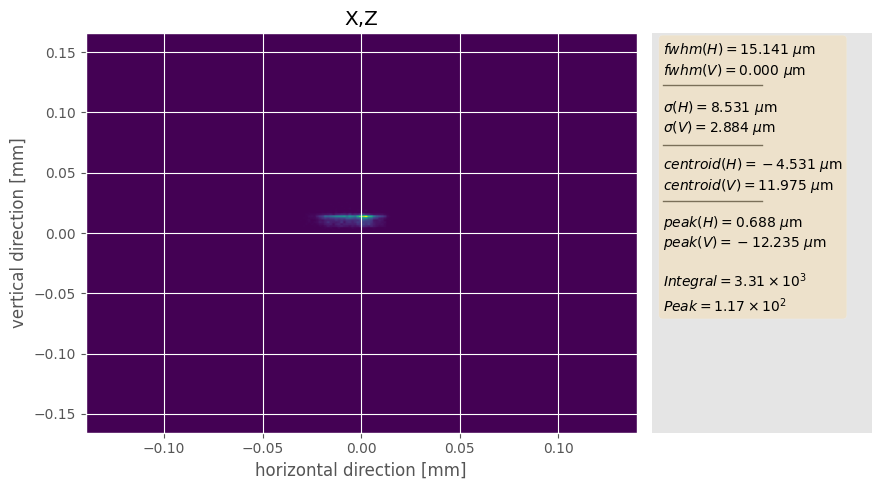

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[1.4026298475624497, 12.2408535139686, 0.013964774502669225]


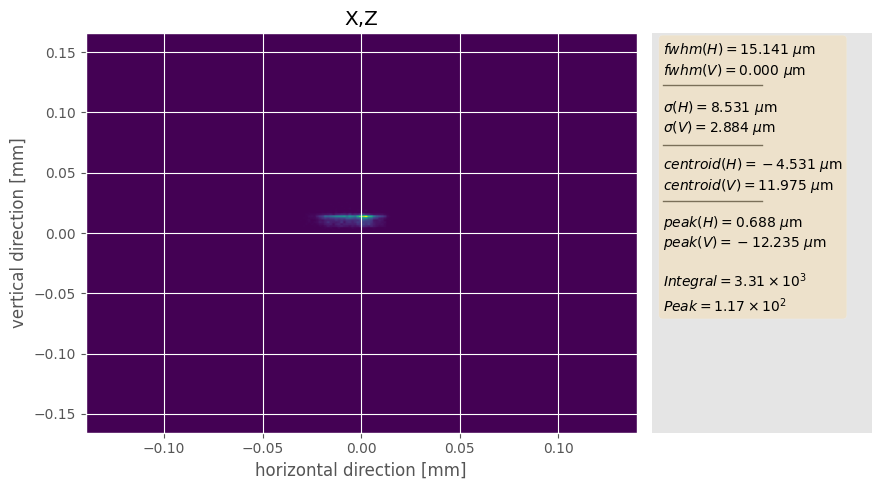

In [77]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

#### calculation over noise

In [83]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [84]:
cp = dt.replace(cp, calculate_over_noise=True)

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


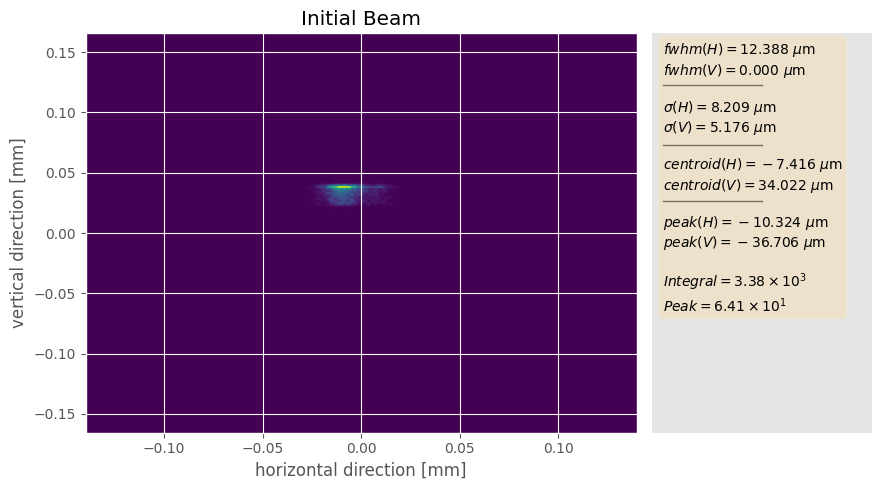

In [85]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [87]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.234e-02
Perturbed beam system log_weighted_sum_intensity: 1.483e+00
Perturbed beam system peak_distance: 3.921e-02


In [88]:
opt_params = OptimizationParameters()

In [89]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
)

In [90]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [91]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-12 20:59:08,466] A new study created in memory with name: no-name-c594c399-041f-47a6-8214-3d5f10185bc8


In [92]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-05-12 20:59:17,362] Trial 0 finished with values: [0.012339843749999968, 1.481799914756045, 0.03921365641918598] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:24,134] Trial 1 finished with values: [0.01653317716791372, 1.5176863286135436, 0.03204881288945489] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008, 'vb_bender': -4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0144}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:31,977] Trial 2 finished with values: [0.043995205704712756, 1.1822563032197662, 0.02263763252105771] and parameters: {'hb_1': -2.5, 'hb_2': -6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.014700000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.00084, 'vb_trans': 0.005000000000000001}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:36,944] Trial 3 finished with values: [0.009597656249999975, 1.8667267189299428, 0.033577208011650796] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0115, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.008800000000000002}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:44,541] Trial 4 finished with values: [0.035848109784166346, 3.796610459654613, 0.11717188035553171] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0023, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.014199999999999999}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:52,254] Trial 5 finished with values: [0.04005945460130596, 3.7974912680114747, 0.11889024255304767] and parameters: {'hb_1': -1.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 1.0, 'vb_pitch': -0.00046, 'vb_trans': 0.0149}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 20:59:57,138] Trial 6 finished with values: [0.01572686376155182, 2.66930707319487, 0.07069082423319044] and parameters: {'hb_1': -9.5, 'hb_2': 3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.002899999999999998, 'vb_bender': 5.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.002999999999999999}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:00:04,677] Trial 7 finished with values: [0.053497341909955205, 4.052069619704467, 0.1407076895694091] and parameters: {'hb_1': -4.5, 'hb_2': 11.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.009400000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.013500000000000002}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:00:12,491] Trial 8 finished with values: [0.015428226295526495, 3.6164195917964546, 0.10287098437568347] and parameters: {'hb_1': 7.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0024999999999999988, 'vb_bender': -4.0, 'vb_pitch': -0.00098, 'vb_trans': -0.0139}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:00:20,244] Trial 9 finished with values: [0.0646255403418611, 3.853428389005611, 0.08717687234402134] and parameters: {'hb_1': -11.5, 'hb_2': -9.5, 'hb_pitch': -0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': 1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0097}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:00:40,819] Trial 10 finished with values: [0.055695549893632165, 3.580659974459513, 0.07747105765589181] and parameters: {'hb_1': 11.5, 'hb_2': -8.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.013400000000000002, 'vb_bender': 10.0, 'vb_pitch': -0.00054, 'vb_trans': 0.011600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:00:58,650] Trial 11 finished with values: [0.037019531249999904, 2.6628066034235287, 0.07759298977304688] and parameters: {'hb_1': -12.5, 'hb_2': -4.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': -0.012199999999999999, 'vb_bender': -3.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': 0.0028000000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.01

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:01:15,606] Trial 12 finished with values: [0.006855468749999982, 2.5920849129267265, 0.06893150670135816] and parameters: {'hb_1': -2.5, 'hb_2': 2.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0073999999999999995, 'vb_bender': -10.0, 'vb_pitch': -0.00017999999999999993, 'vb_trans': 0.010700000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:01:33,402] Trial 13 finished with values: [0.022176934103928733, 3.141144329353349, 0.05375310450614989] and parameters: {'hb_1': 1.5, 'hb_2': -12.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0016999999999999984, 'vb_bender': -7.0, 'vb_pitch': 0.00084, 'vb_trans': 0.002700000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:01:52,529] Trial 14 finished with values: [0.2570665900203893, 3.8439115153712478, 0.15065084600657358] and parameters: {'hb_1': 2.5, 'hb_2': 3.5, 'hb_pitch': -0.0008, 'hb_trans': 0.012900000000000002, 'vb_bender': 8.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': 0.002100000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:09,437] Trial 15 finished with values: [0.046763576066301576, 0.8800852739962066, 0.022456238723866713] and parameters: {'hb_1': -0.5, 'hb_2': -3.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.014400000000000003, 'vb_bender': 7.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': 0.004200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:27,137] Trial 16 finished with values: [0.01409085899187502, 2.065469903357543, 0.03368011614500849] and parameters: {'hb_1': -11.5, 'hb_2': -0.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0063999999999999994, 'vb_bender': -6.0, 'vb_pitch': 0.00034, 'vb_trans': -0.004899999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.01490000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:02:42,606] Trial 17 finished with values: [0.03045520532273573, 2.864876703131532, 0.08044042131147643] and parameters: {'hb_1': 11.5, 'hb_2': 5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.013300000000000003, 'vb_bender': 7.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': 0.0045000000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:00,337] Trial 18 finished with values: [0.04262797844736224, 1.2741231406662927, 0.017220029696838775] and parameters: {'hb_1': -3.5, 'hb_2': -8.5, 'hb_pitch': 0.0, 'hb_trans': 0.013200000000000003, 'vb_bender': -5.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': 0.007600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:19,267] Trial 19 finished with values: [0.053694418624570736, 2.097200856586136, 0.03331955327983585] and parameters: {'hb_1': -5.5, 'hb_2': 10.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.0091, 'vb_bender': 4.0, 'vb_pitch': 0.0008600000000000001, 'vb_trans': -0.008299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.01490000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:03:38,840] Trial 20 finished with values: [0.006375019148255531, 3.116152530795563, 0.07700313514668225] and parameters: {'hb_1': -11.5, 'hb_2': 1.5, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.00030000000000000165, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.0015000000000000013}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:00,218] Trial 21 finished with values: [0.29108173955361955, 3.553859443036181, 0.11416596590555651] and parameters: {'hb_1': -0.5, 'hb_2': 3.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.014499999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.0005, 'vb_trans': 0.010600000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:17,487] Trial 22 finished with values: [0.037055179381156954, 2.4491632120607734, 0.06045499281414606] and parameters: {'hb_1': 12.5, 'hb_2': -8.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.011699999999999999, 'vb_bender': -5.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.0103}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.01490000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:38,572] Trial 23 finished with values: [0.05066495472542224, 3.704927051725107, 0.10641186703995914] and parameters: {'hb_1': -3.5, 'hb_2': -9.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.013300000000000003, 'vb_bender': 5.0, 'vb_pitch': -0.001, 'vb_trans': -0.008299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:04:59,497] Trial 24 finished with values: [0.01946850076335243, 3.1001567973069766, 0.08158412408753989] and parameters: {'hb_1': -5.5, 'hb_2': -1.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.005599999999999999, 'vb_bender': -6.0, 'vb_pitch': -0.00076, 'vb_trans': 0.009300000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.01490000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:21,195] Trial 25 finished with values: [0.030207801831710655, 1.9193032448453176, 0.04162248378170681] and parameters: {'hb_1': -6.5, 'hb_2': -3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.0019000000000000024, 'vb_bender': -9.0, 'vb_pitch': -9.999999999999994e-05, 'vb_trans': -0.008199999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:05:41,107] Trial 26 finished with values: [0.03842500114366449, 3.528315258633254, 0.09380915095624255] and parameters: {'hb_1': -6.5, 'hb_2': -4.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.008300000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0009000000000000002, 'vb_trans': -0.0104}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:02,867] Trial 27 finished with values: [0.057086798718185186, 2.9797243554814585, 0.08565766212499029] and parameters: {'hb_1': 11.5, 'hb_2': -2.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.0143, 'vb_bender': 10.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.0139}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:23,897] Trial 28 finished with values: [0.038289062499999735, 3.6555334227736935, 0.09768961385147075] and parameters: {'hb_1': -11.5, 'hb_2': 3.5, 'hb_pitch': -0.0008, 'hb_trans': -0.010799999999999999, 'vb_bender': 10.0, 'vb_pitch': -0.00017999999999999993, 'vb_trans': 0.007500000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:06:46,200] Trial 29 finished with values: [0.02247263961465135, 3.4150061217127625, 0.08578960162643781] and parameters: {'hb_1': 5.5, 'hb_2': 0.5, 'hb_pitch': -0.0009, 'hb_trans': -0.004799999999999999, 'vb_bender': 3.0, 'vb_pitch': 0.00034, 'vb_trans': -0.0118}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:09,168] Trial 30 finished with values: [0.031576996448552684, 2.8118386313551613, 0.07240801283296076] and parameters: {'hb_1': -8.5, 'hb_2': 6.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': -0.001599999999999999, 'vb_bender': -1.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.004799999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:27,528] Trial 31 finished with values: [0.05377216467624952, 0.8715005190459205, 0.02728500001353348] and parameters: {'hb_1': -2.5, 'hb_2': 9.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.004699999999999999, 'vb_bender': 10.0, 'vb_pitch': -0.00096, 'vb_trans': 0.0103}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:07:48,085] Trial 32 finished with values: [0.06309124300445852, 3.318326498201451, 0.08112962671379055] and parameters: {'hb_1': -8.5, 'hb_2': -9.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.013900000000000003, 'vb_bender': -5.0, 'vb_pitch': 0.0004600000000000001, 'vb_trans': -0.0112}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:10,045] Trial 33 finished with values: [0.01516932073713175, 3.414271717715584, 0.09443005561898882] and parameters: {'hb_1': -6.5, 'hb_2': -0.5, 'hb_pitch': -0.0009, 'hb_trans': 0.004700000000000003, 'vb_bender': -8.0, 'vb_pitch': -7.999999999999999e-05, 'vb_trans': -0.0055}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:31,419] Trial 34 finished with values: [0.030207801831710655, 3.9972630519492727, 0.11969568552258246] and parameters: {'hb_1': -2.5, 'hb_2': 5.5, 'hb_pitch': 0.0009, 'hb_trans': 0.014500000000000002, 'vb_bender': -5.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.014700000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:08:51,488] Trial 35 finished with values: [0.04250390624999989, 2.340949688067163, 0.05119209050984173] and parameters: {'hb_1': -11.5, 'hb_2': 8.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.013000000000000001, 'vb_bender': -2.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.0038000000000000013}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:13,092] Trial 36 finished with values: [0.04664550134161005, 3.5937901441490654, 0.0969839219011601] and parameters: {'hb_1': -2.5, 'hb_2': -10.5, 'hb_pitch': -0.0009, 'hb_trans': -0.0002999999999999982, 'vb_bender': -1.0, 'vb_pitch': 0.0008200000000000002, 'vb_trans': -0.0124}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and ste

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:36,171] Trial 37 finished with values: [0.06493349411387687, 2.8038009457139768, 0.050588735179936194] and parameters: {'hb_1': -11.5, 'hb_2': -7.5, 'hb_pitch': 0.00039999999999999996, 'hb_trans': 0.011600000000000003, 'vb_bender': 9.0, 'vb_pitch': 0.00026000000000000003, 'vb_trans': 0.0086}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:09:58,289] Trial 38 finished with values: [0.04820488895298593, 2.2148169829128035, 0.034620608330136055] and parameters: {'hb_1': -4.5, 'hb_2': -4.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': -0.0069, 'vb_bender': 7.0, 'vb_pitch': 0.0007800000000000001, 'vb_trans': -0.007299999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:22,397] Trial 39 finished with values: [0.024733127584227053, 3.7123363368232924, 0.09674744076756996] and parameters: {'hb_1': -9.5, 'hb_2': -2.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.013400000000000002, 'vb_bender': -8.0, 'vb_pitch': 0.00034, 'vb_trans': -0.0118}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:10:52,333] Trial 40 finished with values: [0.04687139634585409, 3.0627122933265953, 0.07894249112138194] and parameters: {'hb_1': -4.5, 'hb_2': -8.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.004699999999999999, 'vb_bender': 2.0, 'vb_pitch': -0.00078, 'vb_trans': 0.006000000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:18,018] Trial 41 finished with values: [0.030472981477001036, 3.672386183869046, 0.11897530219289579] and parameters: {'hb_1': 8.5, 'hb_2': 12.5, 'hb_pitch': -0.001, 'hb_trans': -0.007199999999999999, 'vb_bender': 6.0, 'vb_pitch': 0.00022000000000000014, 'vb_trans': -0.008199999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:11:42,619] Trial 42 finished with values: [0.008385520590065107, 2.517543037578271, 0.05147376097586266] and parameters: {'hb_1': 5.5, 'hb_2': 7.5, 'hb_pitch': -0.0007, 'hb_trans': 0.009800000000000003, 'vb_bender': -4.0, 'vb_pitch': 0.00038000000000000013, 'vb_trans': -0.007599999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.0149000000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:11,723] Trial 43 finished with values: [0.048015786594921984, 3.0221193532622417, 0.03499798104048857] and parameters: {'hb_1': -10.5, 'hb_2': 9.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.012600000000000004, 'vb_bender': -8.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.0002999999999999982}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:35,574] Trial 44 finished with values: [0.021720666858418697, 3.355563188794475, 0.08981031598094898] and parameters: {'hb_1': 3.5, 'hb_2': 0.5, 'hb_pitch': -0.0009, 'hb_trans': -0.0002999999999999982, 'vb_bender': 5.0, 'vb_pitch': -0.00096, 'vb_trans': -0.0127}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but th

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:12:58,253] Trial 45 finished with values: [0.037055179381156954, 3.6587898010155957, 0.09924124808363458] and parameters: {'hb_1': -0.5, 'hb_2': 10.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0016000000000000007, 'vb_bender': -9.0, 'vb_pitch': -0.0009, 'vb_trans': 0.013600000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:23,479] Trial 46 finished with values: [0.021825306278277473, 2.9196141887120595, 0.08208826759598722] and parameters: {'hb_1': 4.5, 'hb_2': -7.5, 'hb_pitch': 0.0, 'hb_trans': -0.001599999999999999, 'vb_bender': 7.0, 'vb_pitch': 0.0009400000000000001, 'vb_trans': 0.0046}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:13:47,327] Trial 47 finished with values: [0.04938611672717964, 2.278354208985577, 0.053239006555346635] and parameters: {'hb_1': -5.5, 'hb_2': 10.5, 'hb_pitch': -0.0005, 'hb_trans': -0.002599999999999998, 'vb_bender': -5.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': -0.005099999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.01490000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:14:08,375] Trial 48 finished with values: [0.00733784669645152, 3.7769778954682103, 0.1257562386726559] and parameters: {'hb_1': -9.5, 'hb_2': 1.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.0104, 'vb_bender': 2.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': 0.0131}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-12 21:14:30,288] Trial 49 finished with values: [0.03476142552761474, 2.5762877754936504, 0.05375310450614989] and parameters: {'hb_1': -5.5, 'hb_2': 7.5, 'hb_pitch': -0.0005, 'hb_trans': -0.010799999999999999, 'vb_bender': 5.0, 'vb_pitch': 0.00023999999999999998, 'vb_trans': 0.004}. 


/tmp/ipykernel_4113294/2661359174.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

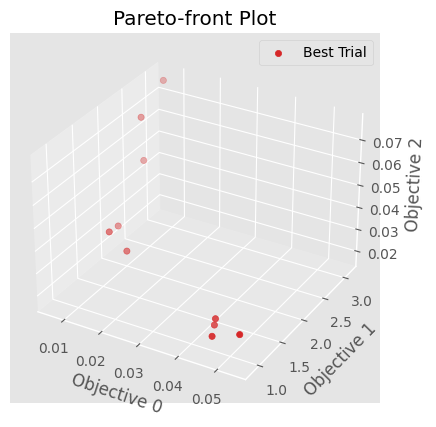

In [93]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
# plt.xscale('log')
# plt.yscale('log')
# plt.scatter(*attribs_focus.values(), color='green')

In [94]:
opt_params.params["loss_parameters"]

['fwhm', 'log_weighted_sum_intensity', 'peak_distance']

/tmp/ipykernel_4113294/2536437509.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='fwhm'>

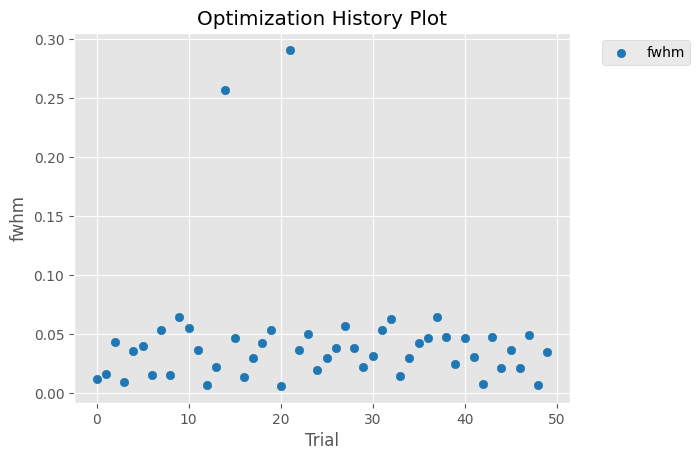

In [95]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="fwhm"
)

/tmp/ipykernel_4113294/605322601.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='lwsi'>

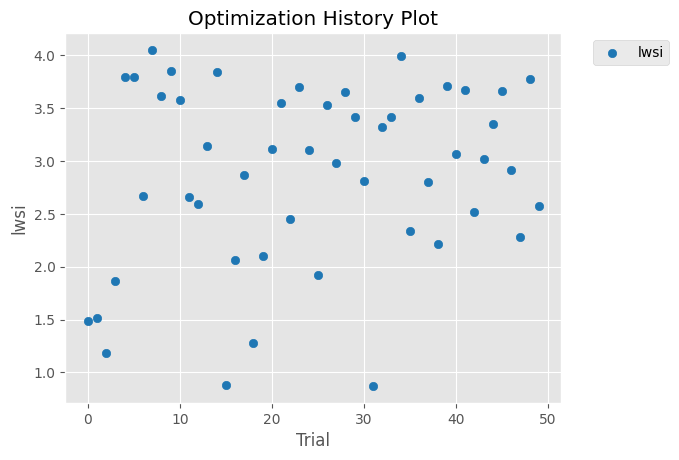

In [96]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="lwsi"
)

/tmp/ipykernel_4113294/3927795367.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='peak_location'>

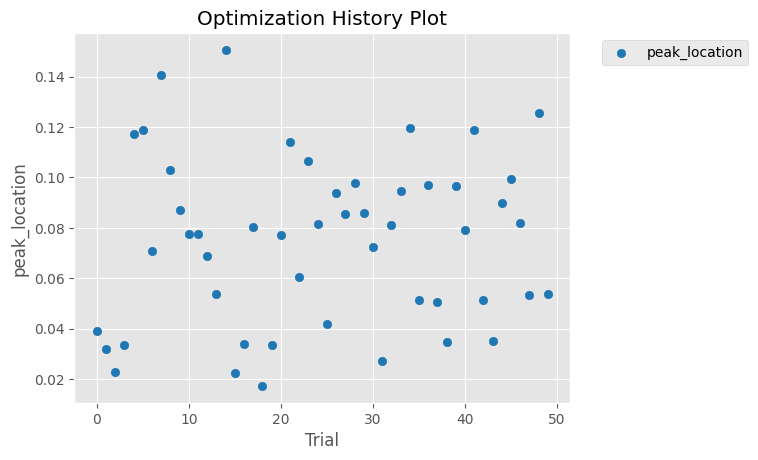

In [97]:
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[2], target_name="peak_location"
)

In [98]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

-7.240394630001301 4.400859728841574
-7.12569429210545 4.561658796835993
-6.744391479923598 3.2617253479694663
-7.41595764670115 6.467093102612478
-6.7048879738881855 13.357592007804568
-6.986573951441009 2.4111053022354936
-6.974668316447696 3.57556476776561
-6.482678248417459 22.559415797542542
-6.6619563271966555 2.3904951471988465
-6.8246484556943665 12.398097551549121


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.012339843749999968, 1.481799914756045, 0.03921365641918598]


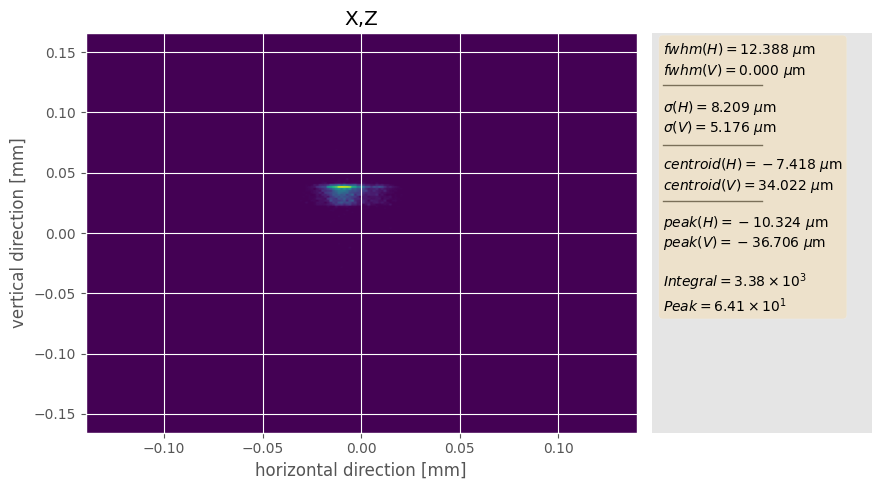

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.01653317716791372, 1.5176863286135436, 0.03204881288945489]


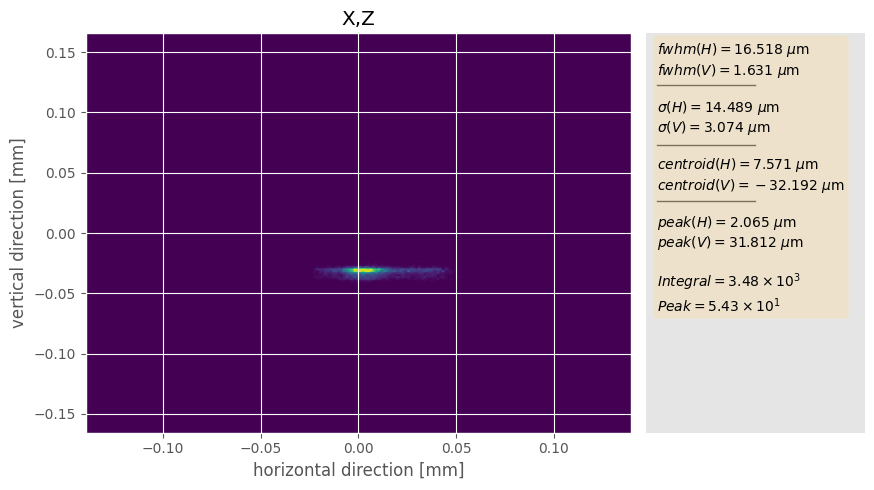

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.043995205704712756, 1.1822563032197662, 0.02263763252105771]


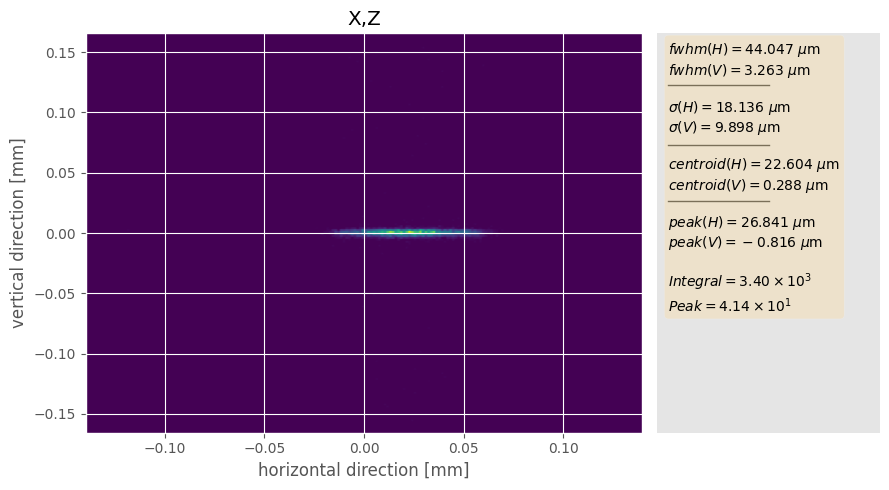

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.009597656249999975, 1.8667267189299428, 0.033577208011650796]


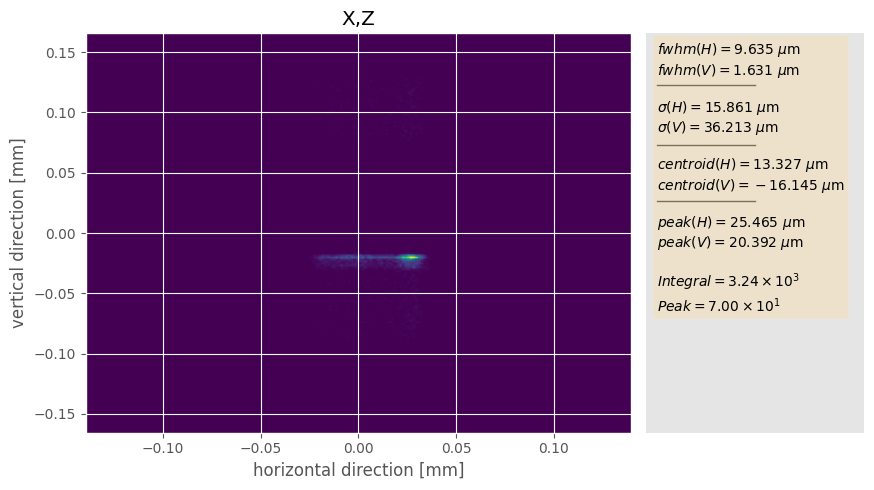

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.006855468749999982, 2.5920849129267265, 0.06893150670135816]


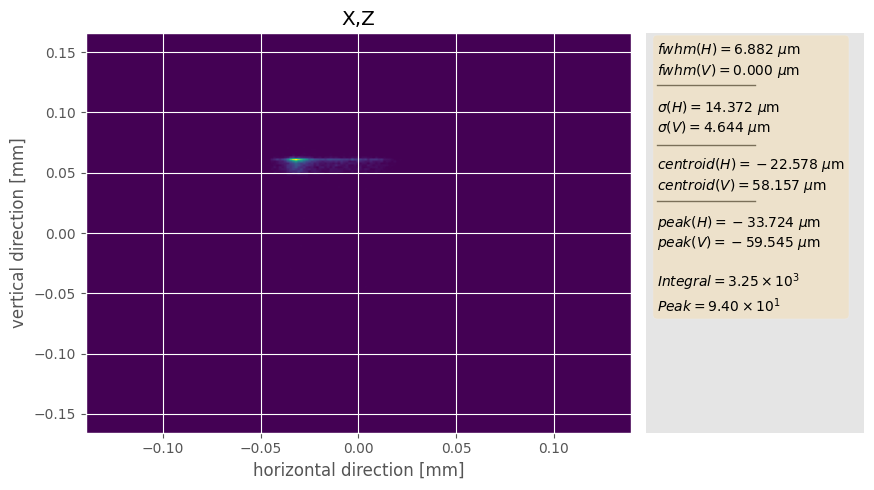

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.046763576066301576, 0.8800852739962066, 0.022456238723866713]


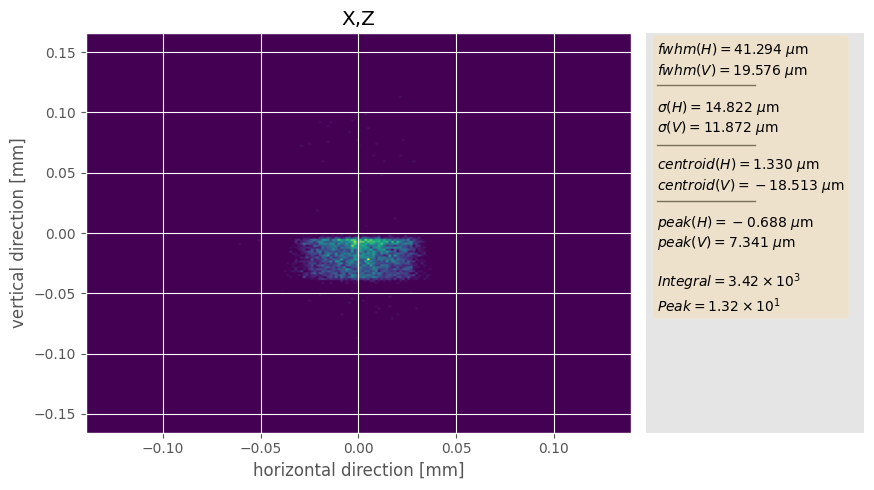

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.04262797844736224, 1.2741231406662927, 0.017220029696838775]


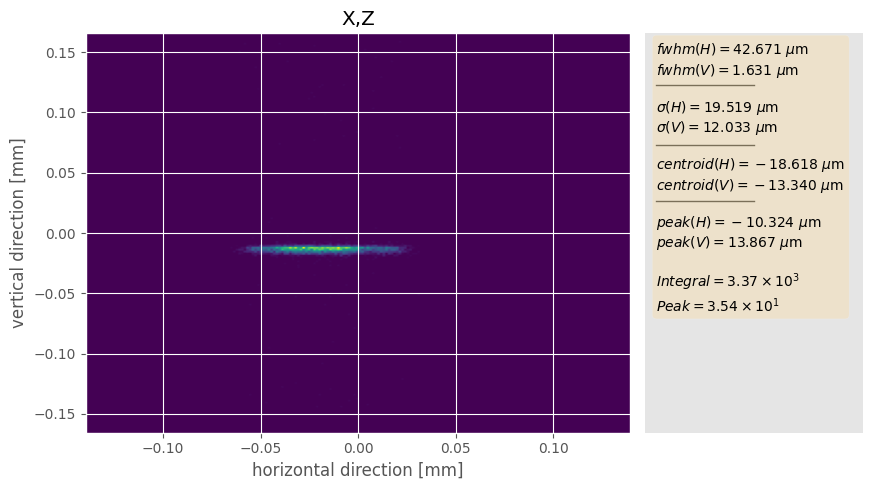

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.006375019148255531, 3.116152530795563, 0.07700313514668225]


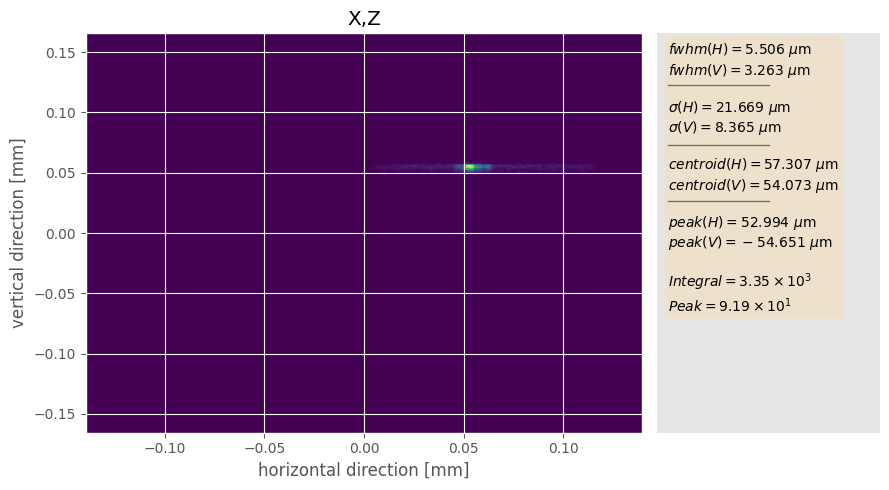

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.05377216467624952, 0.8715005190459205, 0.02728500001353348]


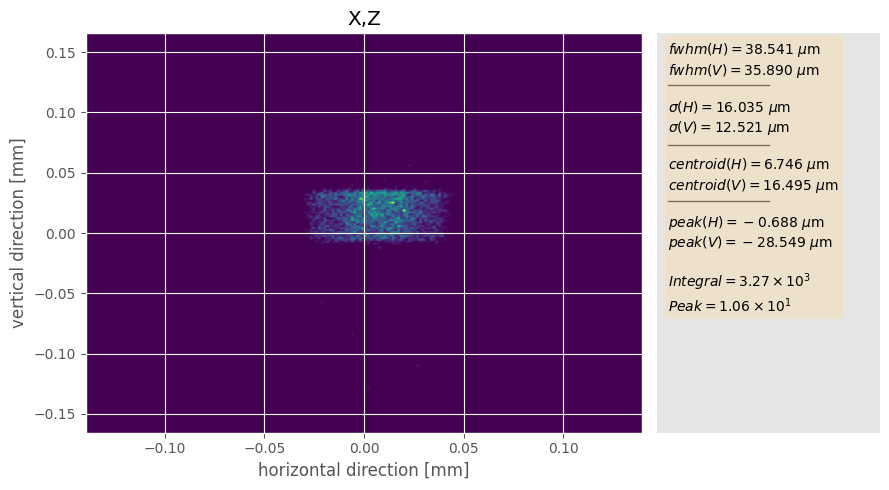

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.008385520590065107, 2.517543037578271, 0.05147376097586266]


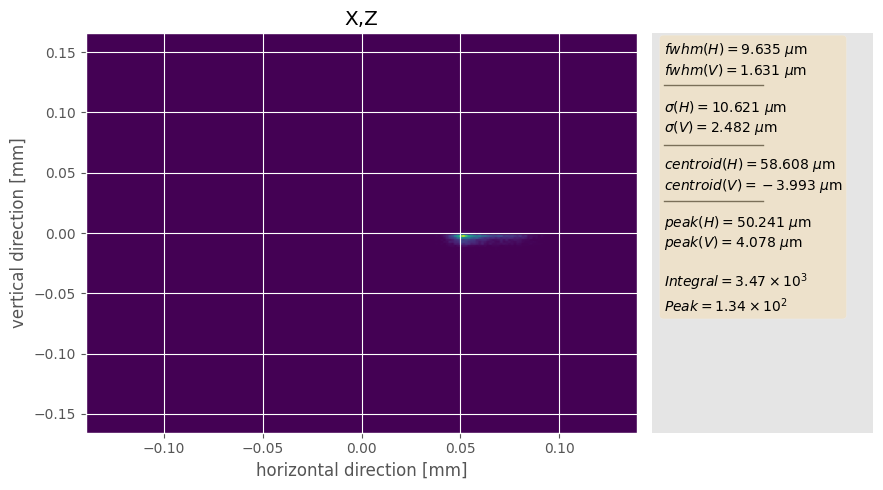

In [99]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_79485/Downstream_HKB_bender_profile.dat written to disk.
[0.009597656249999975, 1.8667267189299428, 0.033577208011650796]


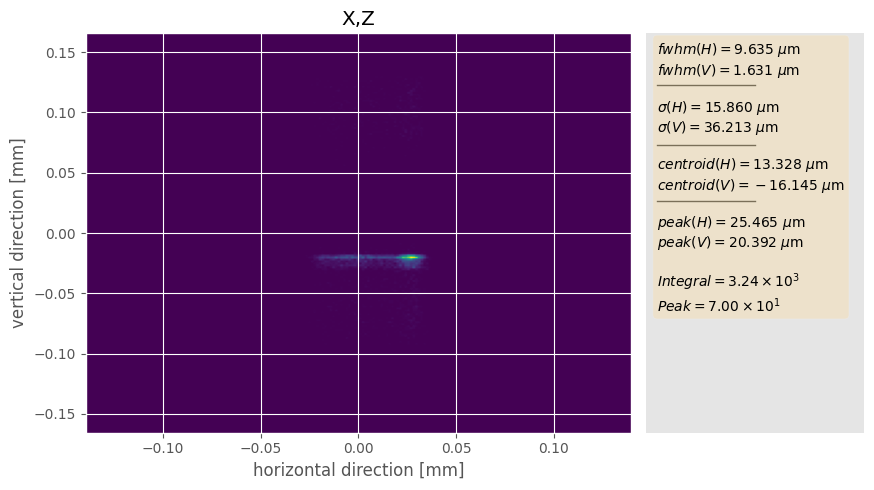

In [100]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)